In [2]:
import numpy as np
import ipywidgets as widgets
import matplotlib.pyplot as plt
%matplotlib inline

## Reference parameters: concentrations, conductances, potentials and currents

In [3]:
conc_Na_i_ref = 15   # [Na]i reference (mM)
conc_K_i_ref = 140   # [K]i reference  (mM)
conc_Na_o_ref = 150  # [Na]o reference (mM)
conc_K_o_ref = 5     # [K]o reference  (mM)

G_K_ref = 2500  # K conductance reference (pS)
G_Na_ref = 445  # Na conductance reference (pS)

E_K_ref = -0.06*np.log10(conc_K_i_ref / conc_K_o_ref)  # K equilibrium potential (V)
E_Na_ref = -0.06*np.log10(conc_Na_i_ref / conc_Na_o_ref) # Na equilibrium potential (V)

Vm_init = ( (E_K_ref)*G_K_ref + (E_Na_ref)*G_Na_ref ) \
           / (G_K_ref + G_Na_ref)   # membrane equilibrium potential (V)

I_K_ref = (Vm_init - E_K_ref) * G_K_ref*1e-12 # K current reference (A)
I_Na_ref = (Vm_init - E_Na_ref) * G_Na_ref*1e-12 # Na current reference (A)

In [4]:
Vm_init   #eq corda

-0.06464302366768519

## Reference parameters: cell parameters

In [5]:
cell_radius = 5 # cell radius (um)
cell_vol = (4/3)*np.pi*((cell_radius*1e-6)**3)*1000 # cell volume (L) *slightly different from excel
cell_capacitance = 4*np.pi*(cell_radius**2)*0.01  # cell capacitance (pF)
Rm_ref = 1000/(G_K_ref+G_Na_ref)  # membrane resistance (GOhm)
tau_ref = Rm_ref*cell_capacitance*1e-3  # time constant (s)

In [6]:
tau_ref

0.0010667547210831217

In [7]:
cell_capacitance

3.141592653589793

## Reference parameters: permeabilities and fluxes

In [8]:
R = 8.314  # universal gas constant (J*K-1*mol-1)
T = 310.15 # temperature (K)
F = 96485  # Farady cinstant (C*mol-1)
z = 1      # charge number (+1 for K+ and Na+)

alpha = z*F*Vm_init/(R*T)
# K permeability (C*s-1*V-1)
P_K_ref = ( G_K_ref*1e-12*R*T * ( 1 - np.exp(alpha) )*(Vm_init - E_K_ref) ) \
            / ( (z**2)*(F**2)*Vm_init \
              * (conc_K_o_ref - conc_K_i_ref*(np.exp(alpha)) ) )
# Na permeability (C*s-1*V-1)
P_Na_ref = ( G_Na_ref*1e-12*R*T * ( 1 - np.exp(alpha) )*(Vm_init - E_Na_ref) ) \
            / ( (z**2)*(F**2)*Vm_init \
              * (conc_Na_o_ref - conc_Na_i_ref*(np.exp(alpha)) ) )

J_K_ref = I_K_ref/F    # K flow (mol/s)
J_Na_ref = I_Na_ref/F  # Na flow (mol/s)

In [9]:
print(P_K_ref, P_Na_ref,'\n')
print('PK/PNa = ', P_K_ref/P_Na_ref)

2.9006942086492596e-17 1.456350185708099e-18 

PK/PNa =  19.917559918728607


In [10]:
# membrane equilibrium potential (V) by GHK
Vm_ref = 0.06*np.log10(((P_K_ref*conc_K_o_ref) + (P_Na_ref*conc_Na_o_ref)) \
                         / ((P_K_ref*conc_K_i_ref) + (P_Na_ref*conc_Na_i_ref))) 

In [11]:
Vm_ref

-0.06302824572327581

## number of channels

In [12]:
from IPython.display import display
K_ch_slider = widgets.IntSlider(
    value=20,
    min=0,
    max=20,
    step=1,
    description='K+ (♦)',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)
Na_ch_slider = widgets.IntSlider(
    value=1,
    min=0,
    max=20,
    step=1,
    description='Na+ (■)',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

display(K_ch_slider, Na_ch_slider)

IntSlider(value=20, continuous_update=False, description='K+ (♦)', max=20)

IntSlider(value=1, continuous_update=False, description='Na+ (■)', max=20)

In [13]:
K_channels = K_ch_slider.value
Na_channels = Na_ch_slider.value

In [14]:
def update_params(K_channels, Na_channels, conc_K_i, conc_Na_i, Vm, conc_K_i_Fick, conc_Na_i_Fick, time=0, time_step=None):
    import numpy as np
    global R, T, F, z, cell_vol, conc_K_o_ref, conc_Na_o_ref, P_K_ref, \
                P_Na_ref, cell_capacitance

    # new potential values
    E_K = -0.06*np.log10(conc_K_i/conc_K_o_ref)
    E_Na = -0.06*np.log10(conc_Na_i/conc_Na_o_ref)
    
    P_K = P_K_ref*(K_channels/20) 
    P_Na = P_Na_ref*Na_channels    
    
    # new conducatances (S)
    alpha = z*F*Vm/(R*T)
    G_K = ((z*F)**2)*P_K*Vm*( conc_K_o_ref - conc_K_i*np.exp(alpha) ) \
            / ( R*T*( 1 - np.exp(alpha)) * (Vm - E_K) )
    G_Na = ((z*F)**2)*P_Na*Vm*( conc_Na_o_ref - conc_Na_i*np.exp(alpha) ) \
            / ( R*T*( 1 - np.exp(alpha)) * (Vm - E_Na) )
    
    # if not max calculation
    if time_step!=None:
        tau = cell_capacitance*1e-12 / (G_K + G_Na) # in (s)
#         time_step = tau
#         print('tau=',tau)
        time += time_step
#         print('time=',time)
        # new currents (A)
        I_K = G_K*(Vm - E_K) 
        I_Na = G_Na*(Vm - E_Na) 
        # new flows (mols/s)
        J_K = I_K/F    
        J_Na = I_Na/F  
        # new concentrations (mM)
        conc_K_i -= 1e3*J_K*time_step/cell_vol
        conc_Na_i -= 1e3*J_Na*time_step/cell_vol
        
        # V(t) = A*exp(-t/tau) + D
        # D = Vnew
        # A = Vold - Vnew
        # V(t) = (Vold - Vnew)*exp(-t/tau) + Vnew
        
        
        Vm_old = Vm
        Vm_new = 0.06*np.log10(((P_K*conc_K_o_ref) + (P_Na*conc_Na_o_ref)) \
                         / ((P_K*conc_K_i) + (P_Na*conc_Na_i)))
        A = Vm_old - Vm_new
        
        # new membrane potential function at time t (mV)    
#         Vm = A*np.exp(-1) + Vm_new
        Vm = A*np.exp(-time_step/tau) + Vm_new
    
    
        ### Fick's law ###
        J_K_Fick = P_K*(conc_K_o_ref - conc_K_i_Fick)
        J_Na_Fick = P_Na*(conc_Na_o_ref - conc_Na_i_Fick)
#         print(J_Na_Fick, conc_Na_i_Fick, time, cell_vol)
        # new concentrations (mM)
        conc_K_i_Fick += 1e3*J_K_Fick*time/cell_vol
        conc_Na_i_Fick += 1e3*J_Na_Fick*time/cell_vol
        
    return(G_K, G_Na, conc_K_i, conc_Na_i, Vm, conc_K_i_Fick, conc_Na_i_Fick, time)

### Calculate minimal time step

In [15]:
G_K_max, G_Na_max, conc_K_i, conc_Na_i, Vm, conc_K_i_Fick, conc_Na_i_Fick, time = update_params(20, 20, conc_K_o_ref, conc_Na_o_ref, conc_K_o_ref, conc_Na_o_ref, 0.02)
print('G_K_max = ',G_K_max,'\nG_Na_max = ',G_Na_max)
time_step = cell_capacitance*1e-12 / (G_K_max + G_Na_max)
print('minimal_time_step = ',time_step)

G_K_max =  5.236121903234571e-10 
G_Na_max =  1.5773383661251637e-08
minimal_time_step =  0.00019277127405577393


### calculate t1 data

In [16]:
time = 0

In [17]:
print('G_K = ',G_K_ref*1e-12,'\nG_Na = ',G_Na_ref*1e-12)
G_K1, G_Na1, conc_K_i1, conc_Na_i1, Vm1, conc_K_i_Fick1, conc_Na_i_Fick1, time1 = update_params(K_channels, Na_channels, conc_K_i_ref, conc_Na_i_ref, Vm_ref, conc_K_i_ref, conc_Na_i_ref, time = time, time_step = time_step)
print('G_K = ',G_K1,' G_Na = ',G_Na1, ' [K+]i = ', conc_K_i1, ' [Na+]i = ', conc_Na_i1, ' Vm = ',Vm1)
print(' [K+]i Fick = ', conc_K_i_Fick1, ' [Na+]i Fick = ', conc_Na_i_Fick1)

G_K =  2.5e-09 
G_Na =  4.45e-10
G_K =  2.523861559991e-09  G_Na =  4.420234209297284e-10  [K+]i =  139.999770781885  [Na+]i =  15.000207507599766  Vm =  -0.06302823898339559
 [K+]i Fick =  139.99855828501742  [Na+]i Fick =  15.000072384116752


### calculate t2 data

In [18]:
print('G_K = ',G_K1,' G_Na = ',G_Na1, ' [K+]i = ', conc_K_i1, ' [Na+]i = ', conc_Na_i1, ' Vm = ',Vm1)
G_K2, G_Na2, conc_K_i2, conc_Na_i2, Vm2, conc_K_i_Fick2, conc_Na_i_Fick2, time2 = update_params(K_channels, Na_channels, conc_K_i1, conc_Na_i1, Vm1, conc_K_i_Fick1, conc_Na_i_Fick1, time1, time_step = time_step)
# print('G_K_max = ',G_K_max,'\nG_Na_max = ',G_Na_max)
print('G_K = ',G_K2,' G_Na = ',G_Na2, ' [K+]i = ', conc_K_i2, ' [Na+]i = ', conc_Na_i2, ' Vm = ',Vm2)
print(' [K+]i Fick = ', conc_K_i_Fick2, ' [Na+]i Fick = ', conc_Na_i_Fick2)

G_K =  2.523861559991e-09  G_Na =  4.420234209297284e-10  [K+]i =  139.999770781885  [Na+]i =  15.000207507599766  Vm =  -0.06302823898339559
G_K =  2.523859549011277e-09  G_Na =  4.420246452151368e-10  [K+]i =  139.99954156429857  [Na+]i =  15.000415015154902  Vm =  -0.06302822662509289
 [K+]i Fick =  139.99567488584552  [Na+]i Fick =  15.000217152272635


In [19]:
# colocar lei de fick (com potencial depois?) DONE
# pensar no tamanho do vetor

In [20]:
time_vector = np.arange(0,10,time_step).tolist()

In [21]:
len(time_vector)

51875

In [22]:
len(time_vector)

51875

In [23]:
time_step

0.00019277127405577393

In [24]:
data = np.empty((len(time_vector),5))
print(data.shape)

(51875, 5)


In [25]:
import pandas as pd
df = pd.DataFrame(data, columns=['[K+]i', '[K+]i (Fick)', '[Na+]i', '[Na+]i (Fick)', 'Vm'], index=time_vector)

In [26]:
df

,[K+]i,[K+]i (Fick),[Na+]i,[Na+]i (Fick),Vm
0.000000,0.0,0.0,0.0,0.0,0.0
0.000193,0.0,0.0,0.0,0.0,0.0
0.000386,0.0,0.0,0.0,0.0,0.0
0.000578,0.0,0.0,0.0,0.0,0.0
0.000771,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...
9.999046,0.0,0.0,0.0,0.0,0.0
9.999239,0.0,0.0,0.0,0.0,0.0
9.999432,0.0,0.0,0.0,0.0,0.0
9.999624,0.0,0.0,0.0,0.0,0.0


In [27]:
# new_time_vector = []
for counter,t in enumerate(time_vector):
    if t==0:
#         time = 0
        conc_K_i, conc_Na_i, Vm, conc_K_i_Fick, conc_Na_i_Fick = conc_K_i_ref, conc_Na_i_ref, Vm_ref, conc_K_i_ref, conc_Na_i_ref
    else:
        G_K, G_Na, conc_K_i, conc_Na_i, Vm, conc_K_i_Fick, conc_Na_i_Fick, time = update_params(K_channels, Na_channels, conc_K_i, conc_Na_i, Vm, conc_K_i_Fick, conc_Na_i_Fick, time = t, time_step = time_step)
    df.iloc[counter,:] = [conc_K_i, conc_K_i_Fick, conc_Na_i, conc_Na_i_Fick, Vm]
#     new_time_vector.append(time)
# df['time'] = new_time_vector
# df.set_index('time', inplace=True)

#     df.rename(index={df.index[counter]:time})
    
#     index_as_list = df.index.tolist()
#     index_as_list[counter] = time
#     df.index = index_as_list

In [28]:
df['Vm'] *= 1000

In [29]:
df

,[K+]i,[K+]i (Fick),[Na+]i,[Na+]i (Fick),Vm
0.000000,140.000000,140.000000,15.000000,15.000000,-63.028246
0.000193,139.999771,139.997117,15.000208,15.000145,-63.028239
0.000386,139.999542,139.992792,15.000415,15.000362,-63.028227
0.000578,139.999312,139.987025,15.000623,15.000651,-63.028210
0.000771,139.999083,139.979817,15.000830,15.001013,-63.028189
...,...,...,...,...,...
9.999046,128.322973,5.000000,25.584656,150.000000,-60.878790
9.999239,128.322752,5.000000,25.584857,150.000000,-60.878747
9.999432,128.322531,5.000000,25.585057,150.000000,-60.878705
9.999624,128.322310,5.000000,25.585258,150.000000,-60.878663


In [30]:
test_vector = time_vector

In [33]:
test_vector = df['[K+]i'].values

In [38]:
len(test_vector)

51875

In [36]:
test_vector.shape

(51875,)

In [41]:
a = []
print(len(a))

0


<AxesSubplot:>

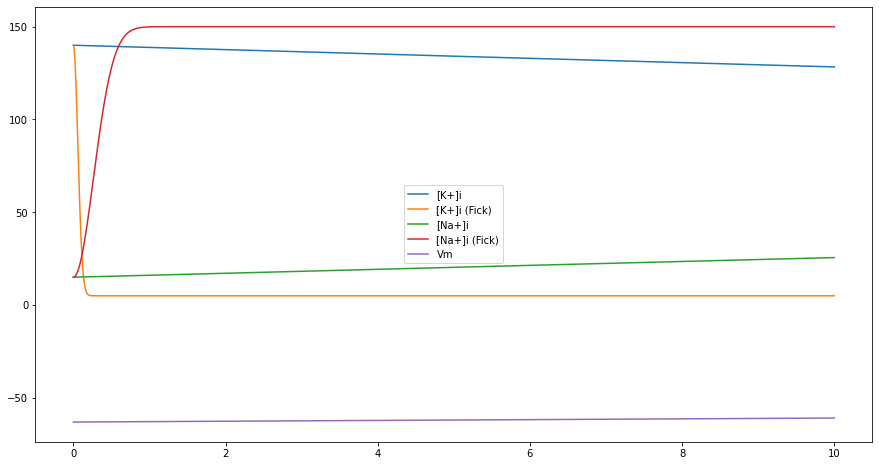

In [37]:
df.plot(figsize=(15,8))

<AxesSubplot:>

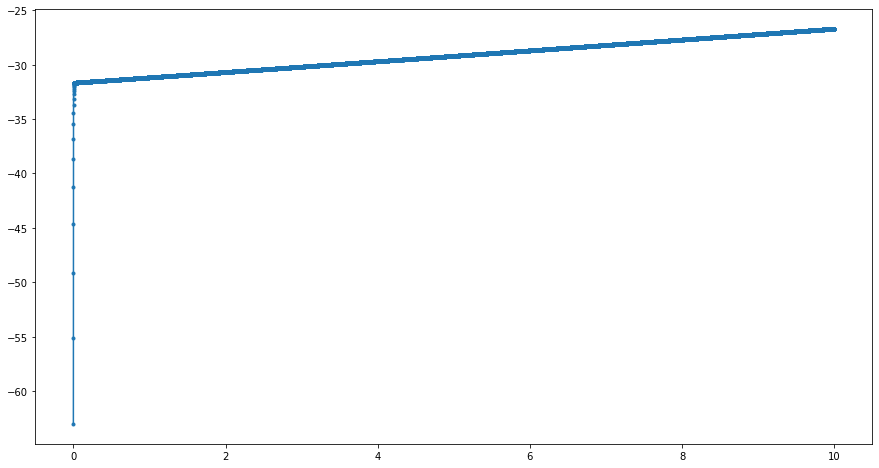

In [56]:
df['Vm'].plot(marker='.',figsize=(15,8))